In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import pandas as pd
import numpy as np

from scipy.spatial.distance import cdist

from sklearn import preprocessing
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import LinearSVR

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import seaborn as sns
from windrose import WindroseAxes, WindAxes, plot_windrose

In [2]:
# 读取原始数据
rawdata_df = pd.read_excel(io=r'./风电数据集.xlsx')
rawdata_df

,DATATIME,WINDSPEED,WINDDIRECTION,TEMPERATURE,HUMIDITY,PRESSURE,WINDPOWER
0,2021-10-02 00:00:00,5.3,216,2.8,66,821,19749.881818
1,2021-10-02 00:15:00,5.3,214,2.8,66,821,20855.945455
2,2021-10-02 00:30:00,5.3,213,2.8,66,821,21499.701515
3,2021-10-02 00:45:00,5.1,213,2.8,66,821,22142.492424
4,2021-10-02 01:00:00,5.1,212,2.8,66,821,22786.248485
...,...,...,...,...,...,...,...
39434,2022-11-16 22:45:00,6.3,268,-4.2,53,821,30797.600000
39435,2022-11-16 23:00:00,6.3,270,-4.1,53,821,30684.900000
39436,2022-11-16 23:15:00,6.2,270,-4.1,53,821,30603.560000
39437,2022-11-16 23:30:00,6.1,270,-4.2,53,821,30553.580000


In [3]:
## 数据清洗
print(np.any(rawdata_df.isna())) # 检查是否存在缺失值
rawdata_df = rawdata_df.dropna().drop_duplicates(subset=rawdata_df.columns[0]) # 删掉含缺失值的样本点

# 去除重复值（看时间） 去除时间数据
rawdata_df = rawdata_df.iloc[:, 1:7]

False


In [4]:
## 划分数据集
sample_num = rawdata_df.shape[0]
sample_divnum = round(sample_num * 0.8)
# 打乱数据集
index_list = np.random.permutation(sample_num)
# 训练集/测试集划分
trs_idx = sorted(index_list[0:sample_divnum])
tes_idx = sorted(index_list[sample_divnum:])
trainSet_df = rawdata_df.iloc[trs_idx, :]
testSet_df = rawdata_df.iloc[tes_idx, :]

In [5]:
## 训练集原始数据统计特征分析 rd - raw data
# 均值
speed_rd_mean = np.mean(trainSet_df['WINDSPEED'])
dir_rd_mean = np.mean(trainSet_df['WINDDIRECTION'])
temper_rd_mean = np.mean(trainSet_df['TEMPERATURE'])
humi_rd_mean = np.mean(trainSet_df['HUMIDITY'])
pres_rd_mean = np.mean(trainSet_df['PRESSURE'])
power_rd_mean = np.mean(trainSet_df['WINDPOWER'])
print ("speed_rd_mean = %3.3f" %speed_rd_mean)

# 极差
speed_rd_ediff = trainSet_df['WINDSPEED'].max() - trainSet_df['WINDSPEED'].min()
dir_rd_ediff = trainSet_df['WINDDIRECTION'].max() - trainSet_df['WINDDIRECTION'].min()
temper_rd_ediff = trainSet_df['TEMPERATURE'].max() - trainSet_df['TEMPERATURE'].min()
humi_rd_ediff = trainSet_df['HUMIDITY'].max() - trainSet_df['HUMIDITY'].min()
pres_rd_ediff = trainSet_df['PRESSURE'].max() - trainSet_df['PRESSURE'].min()
power_rd_ediff = trainSet_df['WINDPOWER'].max() - trainSet_df['WINDPOWER'].min()
print ("speed_rd_ediff = %3.3f" %speed_rd_ediff)

# 标准差
speed_rd_std = np.std(trainSet_df['WINDPOWER'])
dir_rd_std = np.std(trainSet_df['WINDDIRECTION'])
temper_rd_std = np.std(trainSet_df['TEMPERATURE'])
humi_rd_std = np.std(trainSet_df['HUMIDITY'])
pres_rd_std = np.std(trainSet_df['PRESSURE'])
power_rd_std = np.std(trainSet_df['WINDPOWER'])
print ("speed_rd_std = %3.3f" %speed_rd_std)

speed_rd_mean = 5.766
speed_rd_ediff = 15.300
speed_rd_std = 16136.928


In [6]:
# 统计特征分析
trainSet_df.describe()

,WINDSPEED,WINDDIRECTION,TEMPERATURE,HUMIDITY,PRESSURE,WINDPOWER
count,31258.000000,31258.000000,31258.000000,31258.000000,31258.000000,31258.000000
mean,5.765894,252.440527,2.436125,56.012285,823.603909,16738.359617
std,2.737089,82.769882,12.080054,21.674455,5.273652,16137.186018
min,0.000000,0.000000,-27.300000,7.000000,807.000000,0.000000
25%,3.800000,220.000000,-6.800000,39.000000,820.000000,363.736979
50%,5.500000,278.000000,2.000000,55.000000,823.000000,12425.079697
75%,7.500000,312.000000,12.400000,71.000000,827.000000,29602.000000
max,15.300000,359.000000,29.500000,100.000000,838.000000,45994.979898


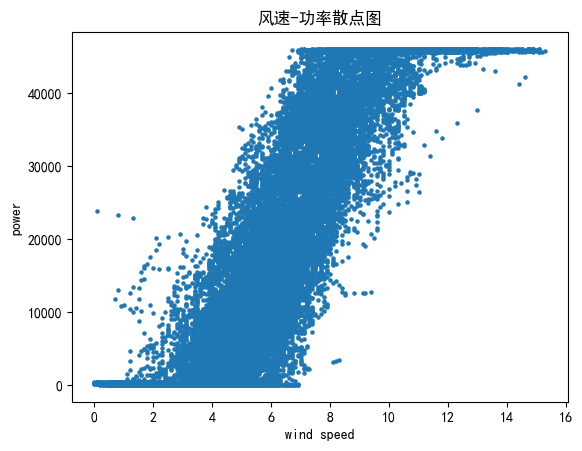

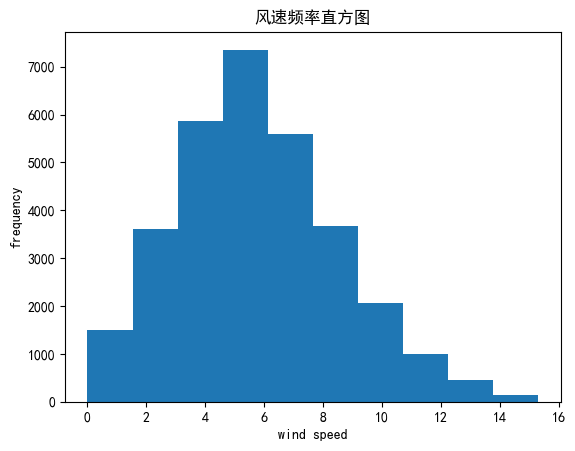

In [7]:
# 设置中文字体
plt.rcParams['font.family'] = 'SimHei' # 黑体
mpl.rcParams['axes.unicode_minus']=False

# 风速-功率散点图
plt.figure()
plt.xlabel("wind speed")
plt.ylabel("power")
plt.title('风速-功率散点图')
plt.scatter(trainSet_df['WINDSPEED'], trainSet_df['WINDPOWER'], s=5)
plt.show()

#风速频率直方图|
plt.figure()
plt.xlabel("wind speed")
plt.ylabel("frequency")
plt.title('风速频率直方图')
plt.hist(trainSet_df['WINDSPEED'])
plt.show()

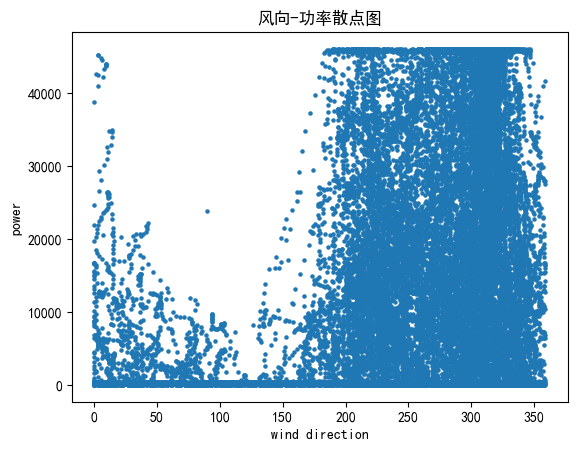

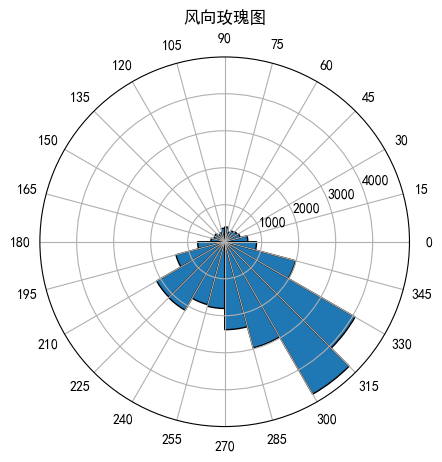

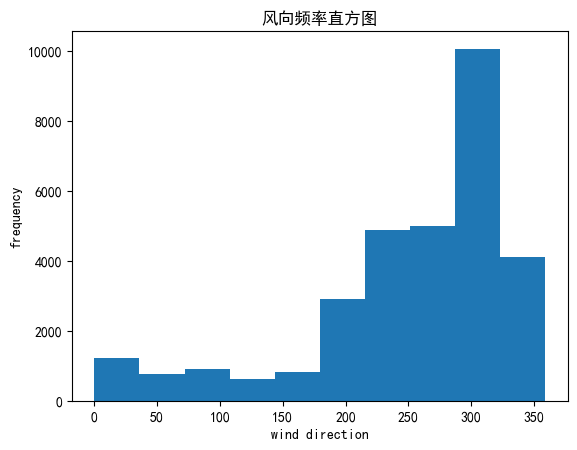

In [8]:
# 风向-功率散点图
plt.figure()
plt.xlabel("wind direction")
plt.ylabel("power")
plt.title('风向-功率散点图')
plt.scatter(trainSet_df['WINDDIRECTION'], trainSet_df['WINDPOWER'], s=5)
plt.show()

# 绘制风向玫瑰图
wind_direction = trainSet_df['WINDDIRECTION']
wind_direction_bins = np.linspace(0, 360, 25) # 角度区间 区间宽度15度
wind_direction_counts, _ = np.histogram(wind_direction, bins=wind_direction_bins) # 统计每个区间的样本点数量
# 获取区间中心角度
angles = [i*15 + 7.5 for i in range(0, 24)]
angles_rad = np.deg2rad(angles)
ax = plt.subplot(111, polar=True)
bars = ax.bar(angles_rad, wind_direction_counts, width=np.deg2rad(15), edgecolor='black', fill=True)
ax.set_thetagrids(range(0, 360, 15), labels=[str(i) for i in range(0, 360, 15)])
plt.title('风向玫瑰图')
plt.show()

#风向频率直方图
plt.figure()
plt.xlabel("wind direction")
plt.ylabel("frequency")
plt.title('风向频率直方图')
plt.hist(trainSet_df['WINDDIRECTION'])
plt.show()

In [9]:
## 数据归一化（最大最小归一化）
min_max_scaler = preprocessing.MinMaxScaler()
# 经最大最小归一化后的数据
data_mms_arr = min_max_scaler.fit_transform(trainSet_df)
# 保持原来的标签
data_mms_df = pd.DataFrame(data_mms_arr, columns=trainSet_df.columns)
# 经预处理后的数据|
data_prd_df = data_mms_df

In [10]:
## 经数据预处理后的数据统计特征分析 prd - pre-dealed
# 均值
speed_prd_mean = np.mean(data_prd_df['WINDSPEED'])
dir_prd_mean = np.mean(data_prd_df['WINDDIRECTION'])
temper_prd_mean = np.mean(data_prd_df['TEMPERATURE'])
humi_prd_mean = np.mean(data_prd_df['HUMIDITY'])
pres_prd_mean = np.mean(data_prd_df['PRESSURE'])
power_prd_mean = np.mean(data_prd_df['WINDPOWER'])
print ("speed_prd_mean = %3.3f" %speed_prd_mean)

# 极差
speed_prd_ediff = data_prd_df['WINDSPEED'].max() - data_prd_df['WINDSPEED'].min()
dir_prd_ediff = data_prd_df['WINDDIRECTION'].max() - data_prd_df['WINDDIRECTION'].min()
temper_prd_ediff = data_prd_df['TEMPERATURE'].max() - data_prd_df['TEMPERATURE'].min()
humi_prd_ediff = data_prd_df['HUMIDITY'].max() - data_prd_df['HUMIDITY'].min()
pres_prd_ediff = data_prd_df['PRESSURE'].max() - data_prd_df['PRESSURE'].min()
power_prd_ediff = data_prd_df['WINDPOWER'].max() - data_prd_df['WINDPOWER'].min()
print ("speed_prd_ediff = %3.3f" %speed_prd_ediff)

# 标准差
speed_prd_std = np.std(data_prd_df['WINDPOWER'])
dir_prd_std = np.std(data_prd_df['WINDDIRECTION'])
temper_prd_std = np.std(data_prd_df['TEMPERATURE'])
humi_prd_std = np.std(data_prd_df['HUMIDITY'])
pres_prd_std = np.std(data_prd_df['PRESSURE'])
power_prd_std = np.std(data_prd_df['WINDPOWER'])
print ("speed_prd_std = %3.3f" %speed_prd_std)

speed_prd_mean = 0.377
speed_prd_ediff = 1.000
speed_prd_std = 0.351


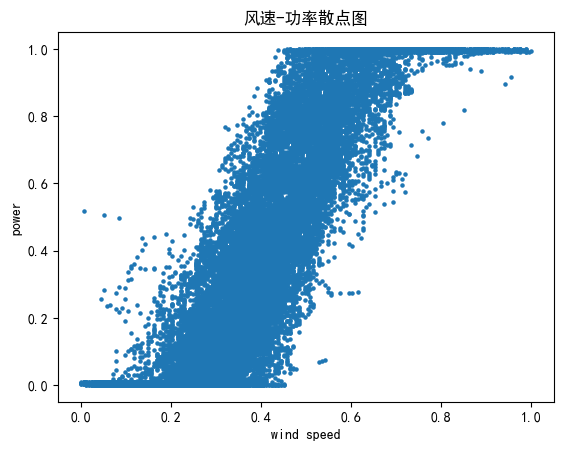

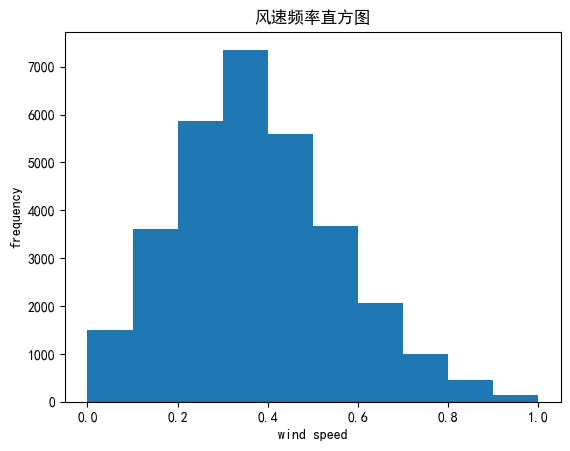

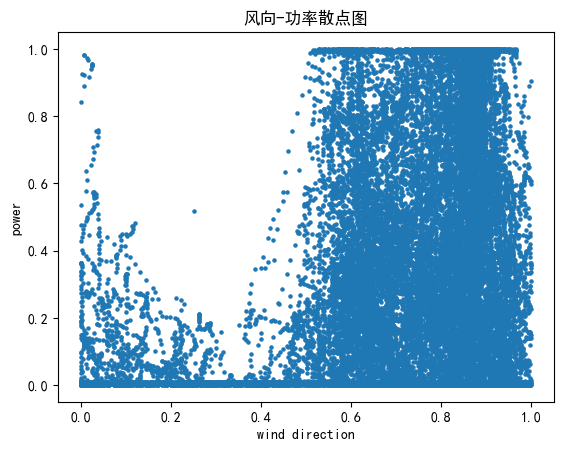

<Figure size 640x480 with 0 Axes>

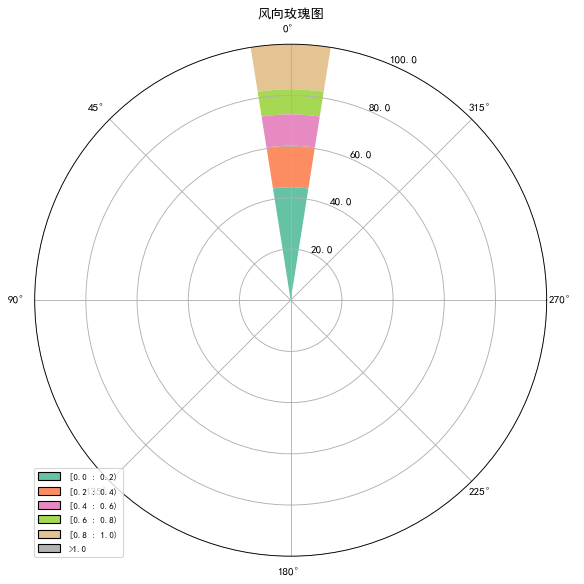

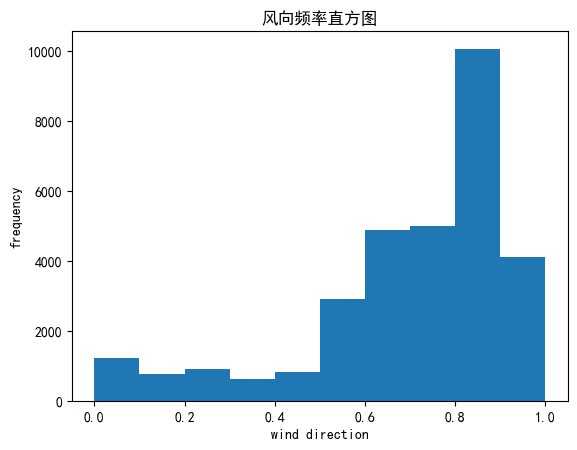

In [11]:
## 经预处理后数据的可视化
# 风速-功率散点图
plt.figure()
plt.xlabel("wind speed")
plt.ylabel("power")
plt.title('风速-功率散点图')
plt.scatter(data_prd_df['WINDSPEED'], data_prd_df['WINDPOWER'], s=5)
plt.show()

#风速频率直方图
plt.figure()
plt.xlabel("wind speed")
plt.ylabel("frequency")
plt.title('风速频率直方图')
plt.hist(data_prd_df['WINDSPEED'])
plt.show()

# 风向-功率散点图
plt.figure()
plt.xlabel("wind direction")
plt.ylabel("power")
plt.title('风向-功率散点图')
plt.scatter(data_prd_df['WINDDIRECTION'], data_prd_df['WINDPOWER'], s=5)
plt.show()

# 风向玫瑰图
plt.figure() #玫瑰图
ax = WindroseAxes.from_ax()
ax.bar(data_prd_df['WINDDIRECTION'], data_prd_df['WINDPOWER'], normed=True, opening=0.8, cmap=cm.Set2)
# 设置x轴刻度标签为角度形式
angles = [270, 315, 0, 45, 90, 135, 180, 225]
ax.set_xticklabels(['{:.0f}°'.format(angle) for angle in angles])
ax.set_legend()
plt.title('风向玫瑰图')
plt.show()

#风向频率直方图
plt.figure()
plt.xlabel("wind direction")
plt.ylabel("frequency")
plt.title('风向频率直方图')
plt.hist(data_prd_df['WINDDIRECTION'])
plt.show()

 0    31161
-1       97
Name: count, dtype: int64


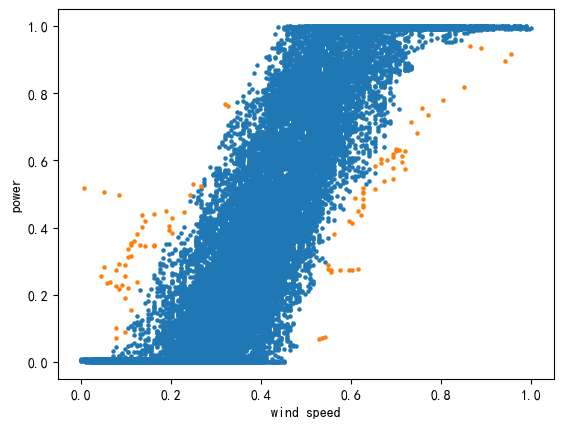

In [12]:
## 针对散点图聚类去除噪声 DBSCAN聚类方法
# 风速-功率数据
speed_power_df = data_prd_df.iloc[:, [0, 5]]

dbscan_sp = DBSCAN(eps=0.03, min_samples=20)  ##领域半径  ##成为核心对象的在领域半径内的最少点数
dbscan_sp.fit_predict(speed_power_df)

#统计每一类的数量
counts = pd.Series(dbscan_sp.labels_).value_counts()
print(counts)

# 将不同类别的点分割开
class_spe_a = speed_power_df.iloc[dbscan_sp.labels_==0]
class_spe_b = speed_power_df.iloc[dbscan_sp.labels_!=0]

# 聚类效果可视化
plt.figure()
plt.xlabel("wind speed")
plt.ylabel("power")
plt.scatter(class_spe_a.iloc[:,0], class_spe_a.iloc[:,1], s=5)
plt.scatter(class_spe_b.iloc[:,0], class_spe_b.iloc[:,1], s=5)
plt.show()

 0    30957
-1      243
 2       38
 1       20
Name: count, dtype: int64


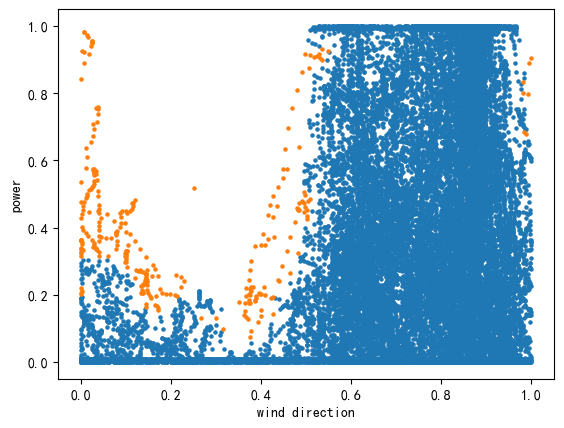

In [13]:
# 风向-功率数据
dir_power_df = data_prd_df.iloc[:, [1, 5]]

dbscan_dp = DBSCAN(eps=0.03, min_samples=20)  ##领域半径  ##成为核心对象的在领域半径内的最少点数
dbscan_dp.fit_predict(dir_power_df)

# 统计每一类的数量
counts = pd.Series(dbscan_dp.labels_).value_counts() 
print(counts)

# 将不同类别的点分割开
class_dir_a = dir_power_df.iloc[dbscan_dp.labels_==0]
class_dir_b = dir_power_df.iloc[dbscan_dp.labels_!=0]
# print(class_a.shape)
# print(class_b.shape)

# 聚类效果可视化
plt.figure()
plt.xlabel("wind direction")
plt.ylabel("power")
plt.scatter(class_dir_a.iloc[:,0], class_dir_a.iloc[:,1], s=5)
plt.scatter(class_dir_b.iloc[:,0], class_dir_b.iloc[:,1], s=5)
plt.show()

 0    30994
-1      141
 1       41
 3       35
 4       24
 2       23
Name: count, dtype: int64


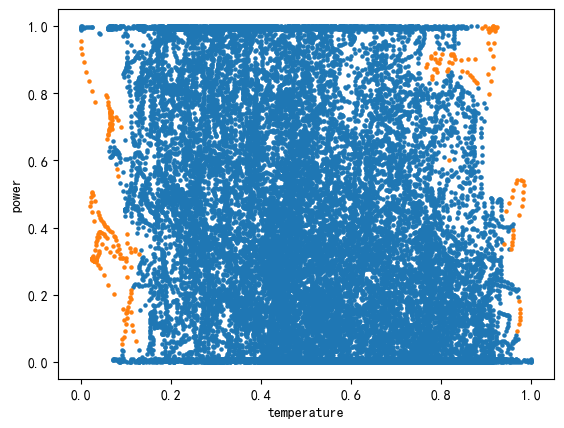

In [14]:
# 温度-功率数据
temper_power_df = data_prd_df.iloc[:, [2, 5]]

dbscan_tp = DBSCAN(eps=0.03, min_samples=20)  ##领域半径  ##成为核心对象的在领域半径内的最少点数
dbscan_tp.fit_predict(temper_power_df)

# 统计每一类的数量
counts = pd.Series(dbscan_tp.labels_).value_counts() 
print(counts)

# 将不同类别的点分割开
class_tem_a = temper_power_df.iloc[dbscan_tp.labels_==0]
class_tem_b = temper_power_df.iloc[dbscan_tp.labels_!=0]

# 聚类效果可视化
plt.figure()
plt.xlabel("temperature")
plt.ylabel("power")
plt.scatter(class_tem_a.iloc[:,0], class_tem_a.iloc[:,1], s=5)
plt.scatter(class_tem_b.iloc[:,0], class_tem_b.iloc[:,1], s=5)
plt.show()

 0    30861
-1      317
 3       24
 1       22
 2       20
 4       14
Name: count, dtype: int64


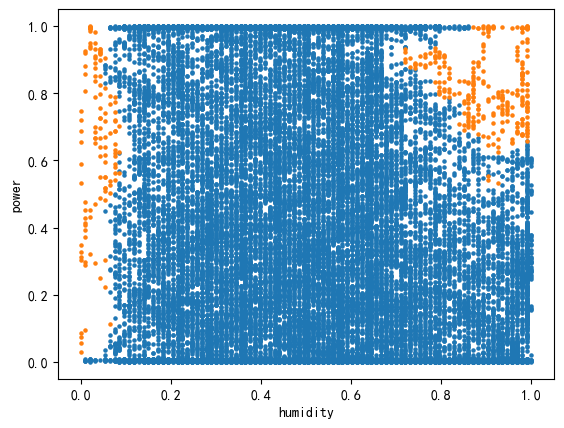

In [15]:
# 湿度-功率数据
humi_power_df = data_prd_df.iloc[:, [3, 5]]

dbscan_hp = DBSCAN(eps=0.03, min_samples=20)  ##领域半径  ##成为核心对象的在领域半径内的最少点数
dbscan_hp.fit_predict(humi_power_df)

# 统计每一类的数量
counts = pd.Series(dbscan_hp.labels_).value_counts() 
print(counts)

# 将不同类别的点分割开
class_humi_a = humi_power_df.iloc[dbscan_hp.labels_==0]
class_humi_b = humi_power_df.iloc[dbscan_hp.labels_!=0]
# print(class_a.shape)
# print(class_b.shape)

# 聚类效果可视化
plt.figure()
plt.xlabel("humidity")
plt.ylabel("power")
plt.scatter(class_humi_a.iloc[:,0], class_humi_a.iloc[:,1], s=5)
plt.scatter(class_humi_b.iloc[:,0], class_humi_b.iloc[:,1], s=5)
plt.show()

 0    30841
-1      366
 1       51
Name: count, dtype: int64


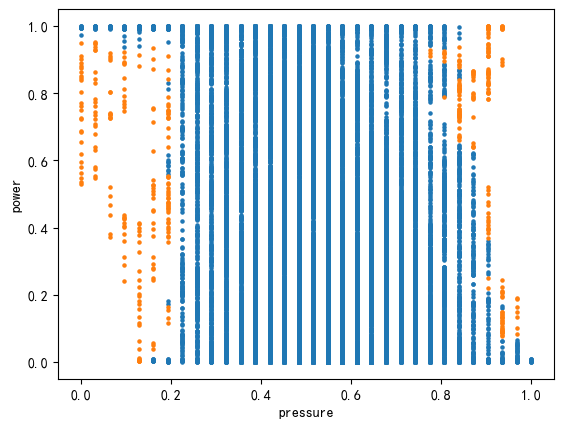

In [16]:
# 压力-功率数据
pres_power_df = data_prd_df.iloc[:, [4, 5]]

dbscan_pp = DBSCAN(eps=0.035, min_samples=35)  ##领域半径  ##成为核心对象的在领域半径内的最少点数
dbscan_pp.fit_predict(pres_power_df)

# 统计每一类的数量
counts = pd.Series(dbscan_pp.labels_).value_counts() 
print(counts)

# 将不同类别的点分割开
class_pres_a = pres_power_df.iloc[dbscan_pp.labels_ == 0]
class_pres_b = pres_power_df.iloc[dbscan_pp.labels_ != 0]
# print(class_a.shape)
# print(class_b.shape)

# 聚类效果可视化
plt.figure()
plt.xlabel("pressure")
plt.ylabel("power")
plt.scatter(class_pres_a.iloc[:,0], class_pres_a.iloc[:,1], s=5)
plt.scatter(class_pres_b.iloc[:,0], class_pres_b.iloc[:,1], s=5)
plt.show()

In [17]:
# 剔除所有离群点的数据集
data_dno_df = data_prd_df.iloc[~((dbscan_sp.labels_ != 0) +
                                 (dbscan_dp.labels_ != 0) +
                                 (dbscan_tp.labels_ != 0) +
                                 (dbscan_hp.labels_ != 0) +
                                 (dbscan_pp.labels_ != 0))]

使用DBSCAN算法共去除1422个离群点


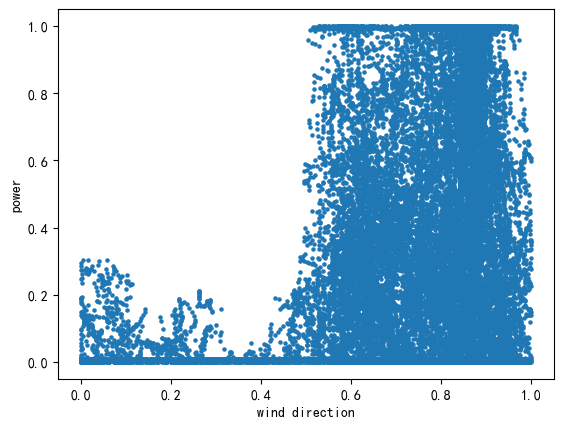

In [18]:
print('使用DBSCAN算法共去除%d个离群点' % (trainSet_df.shape[0] - data_dno_df.shape[0]))

# 查看该数据集的散点图以验证去噪效果
plt.figure()
plt.ylabel("power")
plt.xlabel("wind direction")
plt.scatter(data_dno_df.iloc[:,1], data_dno_df.iloc[:,5], s=5)
plt.show()

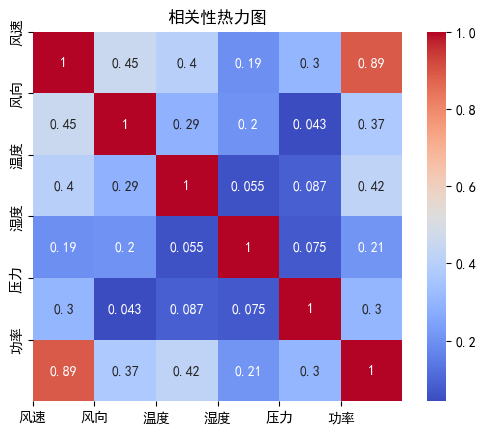

In [19]:
# 计算pearson相关系数矩阵
corr_matrix = np.corrcoef(data_dno_df.values.T)
corr_matrix = np.abs(corr_matrix)

# 特征与功率之间的相关性热力图
plt.figure()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", square=True)
# 设置x轴和y轴的标签
labels = ["风速", "风向", "温度", "湿度", "压力", "功率"]
plt.xticks(range(len(labels)), labels)
plt.yticks(range(len(labels)), labels)
plt.title("相关性热力图")
plt.show()

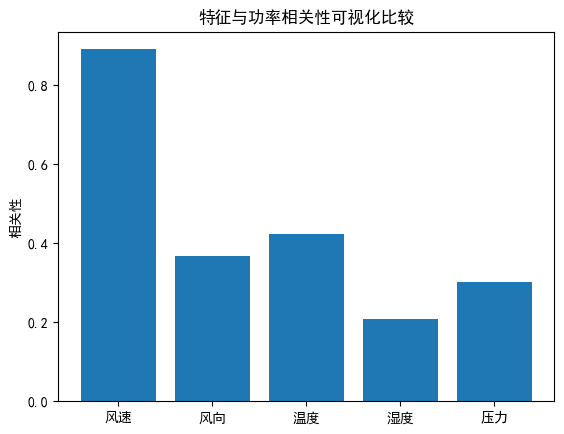

In [20]:
# 特征与功率相关性可视化比较
plt.figure()
plt.ylabel("相关性")
plt.title('特征与功率相关性可视化比较')
plt.bar(['风速', '风向', '温度', '湿度', '压力'], corr_matrix[0:5, 5])
plt.show()

# 结论：风速、风向、温度与功率相关性较高 
main_data_df = data_dno_df.iloc[:, [0, 1, 2, 5]]
# 用于聚类
main_data_fea_df = data_dno_df.iloc[:, [0, 1, 2]]

In [21]:
# 风速-功率
# spe_pow_dno = data_dno_df.iloc[:, [0, 5]]

# # 肘部法判断最佳聚类个数
# mean_dis = []
# for k in range(1, 10):
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(spe_pow_dno)
#     # 计算平均距离
#     mean_dis.append(sum(np.min(cdist(spe_pow_dno, kmeans.cluster_centers_, 'euclidean'), axis=1)) / spe_pow_dno.shape[0])
# plt.figure()
# plt.plot(range(1, 10), mean_dis, 'bo-', mfc='r')
# plt.xlabel('k')
# plt.ylabel('mean distortions')
# plt.show()

# # 最优聚类簇数为3
# kmeans_spe = KMeans(n_clusters = 3).fit(spe_pow_dno)
# #统计每一类的数量
# counts = pd.Series(kmeans_spe.labels_).value_counts()
# print(counts)

# # 将不同类别的点分割开
# kmeans_spe_a = spe_pow_dno.iloc[kmeans_spe.labels_ == 0]
# kmeans_spe_b = spe_pow_dno.iloc[kmeans_spe.labels_ == 1]
# kmeans_spe_c = spe_pow_dno.iloc[kmeans_spe.labels_ == 2]
        
# plt.figure()
# plt.xlabel("wind speed")
# plt.ylabel("power")
# plt.plot(kmeans_spe_a.iloc[:, 0], kmeans_spe_a.iloc[:, 1], 'o', markerfacecolor='none')
# plt.plot(kmeans_spe_b.iloc[:, 0], kmeans_spe_b.iloc[:, 1], 'o', markerfacecolor='none')
# plt.plot(kmeans_spe_c.iloc[:, 0], kmeans_spe_c.iloc[:, 1], 'o', markerfacecolor='none')
# plt.show()

In [22]:
# # 风向-功率
# dir_pow_dno = data_dno_df.iloc[:, [1, 5]]

# mean_dis = []
# for k in range(1, 10):
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(dir_pow_dno)
#     # 计算平均距离
#     mean_dis.append(sum(np.min(cdist(dir_pow_dno, kmeans.cluster_centers_, 'euclidean'), axis=1)) / dir_pow_dno.shape[0])
    
# # 肘部法判断最佳聚类个数
# plt.figure()
# plt.plot(range(1, 10), mean_dis, 'bo-', mfc='r')
# plt.xlabel('k')
# plt.ylabel('mean distortions')
# plt.show()

# # 最优聚类簇数为4
# kmeans_dir = KMeans(n_clusters = 4).fit(dir_pow_dno)
# #统计每一类的数量
# counts = pd.Series(kmeans_dir.labels_).value_counts()
# print(counts)

# # 将不同类别的点分割开
# kmeans_dir_a = dir_pow_dno.iloc[kmeans_dir.labels_ == 0]
# kmeans_dir_b = dir_pow_dno.iloc[kmeans_dir.labels_ == 1]
# kmeans_dir_c = dir_pow_dno.iloc[kmeans_dir.labels_ == 2]
# kmeans_dir_d = dir_pow_dno.iloc[kmeans_dir.labels_ == 3]
        
# plt.figure()
# plt.xlabel("wind speed")
# plt.ylabel("power")
# plt.plot(kmeans_dir_a.iloc[:, 0], kmeans_dir_a.iloc[:, 1], 'o', markerfacecolor='none')
# plt.plot(kmeans_dir_b.iloc[:, 0], kmeans_dir_b.iloc[:, 1], 'o', markerfacecolor='none')
# plt.plot(kmeans_dir_c.iloc[:, 0], kmeans_dir_c.iloc[:, 1], 'o', markerfacecolor='none')
# plt.plot(kmeans_dir_d.iloc[:, 0], kmeans_dir_d.iloc[:, 1], 'o', markerfacecolor='none')
# plt.show()

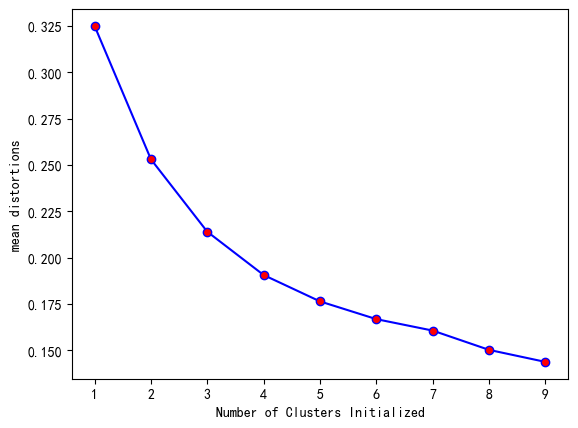

In [23]:
## kmeans聚类 使用筛选得到的3个特征，不使用功率数据
# 基于风速，风向和温度3个特征对训练集进行聚类分类得到3个子集，对每个子集分别训练预测模型
# 基于训练集聚类结果，对测试集进行划分，并使用对应类别的预测模型分别预测，最后将预测结果整合
# 肘部法判断最佳聚类个数
mean_dis = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(main_data_fea_df)
    # 计算平均距离
    mean_dis.append(sum(np.min(cdist(main_data_fea_df, kmeans.cluster_centers_, 'euclidean'), axis=1)) / main_data_fea_df.shape[0])
plt.figure()
plt.plot(range(1, 10), mean_dis, 'bo-', mfc='r')
plt.xlabel('Number of Clusters Initialized')
plt.ylabel('mean distortions')
plt.show()

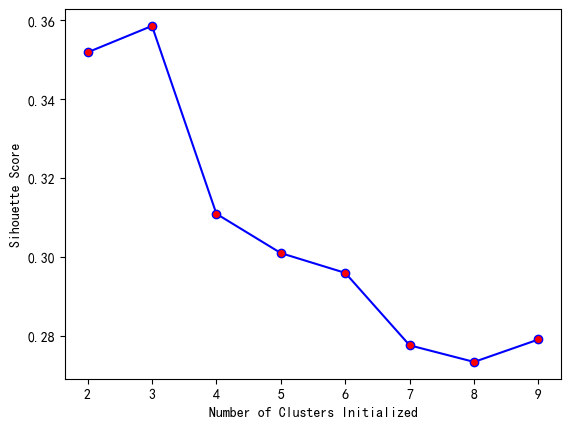

In [24]:
# 轮廓系数法 (运行用时比较长，慎用)
scores = []
# 最少需要划分两类
for k in range(2, 10):
    labels = KMeans(n_clusters=k).fit(main_data_fea_df).labels_
    score = metrics.silhouette_score(main_data_fea_df, labels)
    scores.append(score)
# 通过画图找出最合适的K值
plt.figure()
plt.plot(range(2,10), scores, 'bo-', mfc='r')
plt.xlabel('Number of Clusters Initialized')
plt.ylabel('Sihouette Score')
plt.show()

In [25]:
# 最佳聚类数为3
kmeans =  KMeans(n_clusters = 3).fit(main_data_fea_df)
#统计每一类的数量
counts = pd.Series(kmeans.labels_).value_counts()
print(counts)

2    13345
1    12618
0     3873
Name: count, dtype: int64


In [26]:
# 统计不同类别点的索引
class_a_idx = np.arange(main_data_df.shape[0])[kmeans.labels_ == 0]
class_b_idx = np.arange(main_data_df.shape[0])[kmeans.labels_ == 1]
class_c_idx = np.arange(main_data_df.shape[0])[kmeans.labels_ == 2]

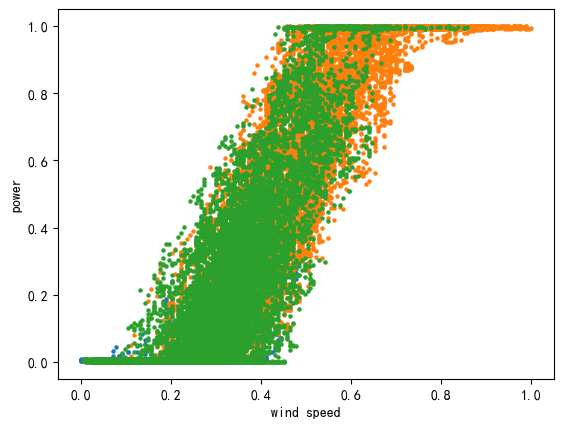

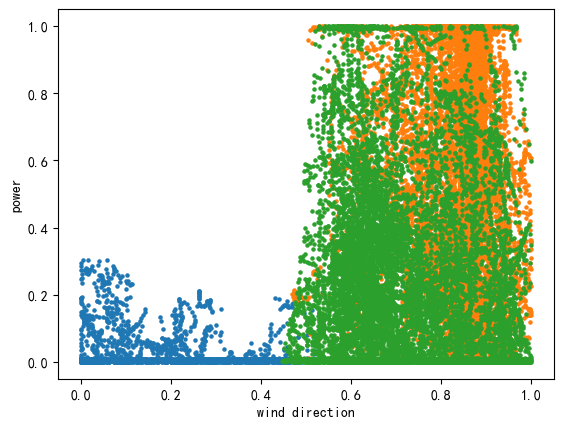

In [27]:
# 聚类结果可视化
plt.figure()
plt.xlabel("wind speed")
plt.ylabel("power")
plt.scatter(main_data_df.iloc[class_a_idx, 0], main_data_df.iloc[class_a_idx, 3], s=5)
plt.scatter(main_data_df.iloc[class_b_idx, 0], main_data_df.iloc[class_b_idx, 3], s=5)
plt.scatter(main_data_df.iloc[class_c_idx, 0], main_data_df.iloc[class_c_idx, 3], s=5)
plt.show()

plt.figure()
plt.xlabel("wind direction")
plt.ylabel("power")
plt.scatter(main_data_df.iloc[class_a_idx, 1], main_data_df.iloc[class_a_idx, 3], s=5)
plt.scatter(main_data_df.iloc[class_b_idx, 1], main_data_df.iloc[class_b_idx, 3], s=5)
plt.scatter(main_data_df.iloc[class_c_idx, 1], main_data_df.iloc[class_c_idx, 3], s=5)
plt.show()

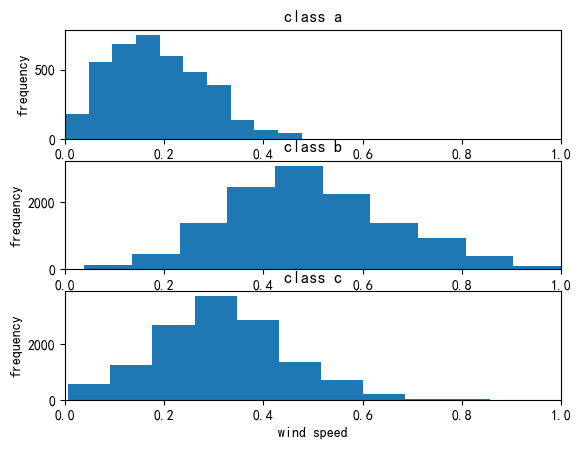

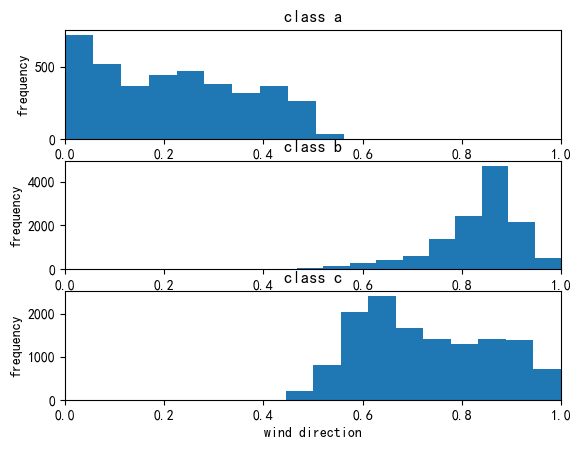

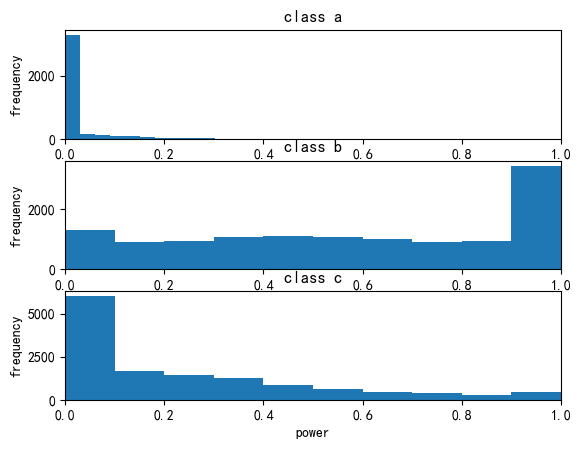

In [28]:
## 3个类别对应的风速和风向分布直方图

#风速频率直方图
plt.figure()
plt.subplot(3, 1, 1)
# plt.xlabel("wind speed")
plt.ylabel("frequency")
plt.title('class a')
plt.xlim(0, 1) # 设置x轴范围
plt.hist(main_data_df.iloc[class_a_idx, 0])

plt.subplot(3, 1, 2)
# plt.xlabel("wind speed")
plt.ylabel("frequency")
plt.title('class b')
plt.xlim(0, 1)
plt.hist(main_data_df.iloc[class_b_idx, 0])

plt.subplot(3, 1, 3)
plt.xlabel("wind speed")
plt.ylabel("frequency")
plt.title('class c')
plt.xlim(0, 1)
plt.hist(main_data_df.iloc[class_c_idx, 0])
plt.show()


#风向频率直方图
plt.figure()
plt.subplot(3, 1, 1)
# plt.xlabel("wind speed")
plt.ylabel("frequency")
plt.title('class a')
plt.xlim(0, 1) # 设置x轴范围
plt.hist(main_data_df.iloc[class_a_idx, 1])

plt.subplot(3, 1, 2)
# plt.xlabel("wind speed")
plt.ylabel("frequency")
plt.title('class b')
plt.xlim(0, 1)
plt.hist(main_data_df.iloc[class_b_idx, 1])

plt.subplot(3, 1, 3)
plt.xlabel("wind direction")
plt.ylabel("frequency")
plt.title('class c')
plt.xlim(0, 1)
plt.hist(main_data_df.iloc[class_c_idx, 1])
plt.show()


#功率频率直方图
plt.figure()
plt.subplot(3, 1, 1)
# plt.xlabel("wind speed")
plt.ylabel("frequency")
plt.title('class a')
plt.xlim(0, 1) # 设置x轴范围
plt.hist(main_data_df.iloc[class_a_idx, 3])

plt.subplot(3, 1, 2)
# plt.xlabel("wind speed")
plt.ylabel("frequency")
plt.title('class b')
plt.xlim(0, 1)
plt.hist(main_data_df.iloc[class_b_idx, 3])

plt.subplot(3, 1, 3)
plt.xlabel("power")
plt.ylabel("frequency")
plt.title('class c')
plt.xlim(0, 1)
plt.hist(main_data_df.iloc[class_c_idx, 3])
plt.show()

In [29]:
## 模型使用的训练集/测试集
# 训练集
train_set_df = main_data_df
# train_set_fed_df = main_data_fea_df
# 测试集数据归一化
tes_scaler = preprocessing.MinMaxScaler()
tes_scaler.fit(testSet_df.iloc[:, [0, 1, 2, 5]])
tes_mms_arr = tes_scaler.fit_transform(testSet_df.iloc[:, [0, 1, 2, 5]])
test_set_df = pd.DataFrame(tes_mms_arr, columns=testSet_df.columns[[0, 1, 2, 5]])
test_set_fea_df = test_set_df.iloc[:, [0,1,2]]
# 测试集标签数据
test_y = test_set_df.values[:, 3]
test_y_dnorm = testSet_df.iloc[:, 5].values

In [30]:
## 根据聚类结果划分不同类别的训练集/测试集
train_set_a_df = train_set_df.iloc[class_a_idx, :]
train_set_b_df = train_set_df.iloc[class_b_idx, :]
train_set_c_df = train_set_df.iloc[class_c_idx, :]

tes_idx_a = np.arange(test_set_df.shape[0])[kmeans.predict(test_set_fea_df) == 0]
tes_idx_b = np.arange(test_set_df.shape[0])[kmeans.predict(test_set_fea_df) == 1]
tes_idx_c = np.arange(test_set_df.shape[0])[kmeans.predict(test_set_fea_df) == 2]
test_set_a_df = test_set_df.iloc[tes_idx_a, :]
test_set_b_df = test_set_df.iloc[tes_idx_b, :]
test_set_c_df = test_set_df.iloc[tes_idx_c, :]

In [31]:
# 将数据导出为CSV文件，在kaggle训练模型
# data_dno_df.to_csv('data_dno.csv', index=False)

Mean Absolute Error: 3768.54640682149
Root Mean Squared Error: 5508.272827650153
R Square: 0.8824935330703629


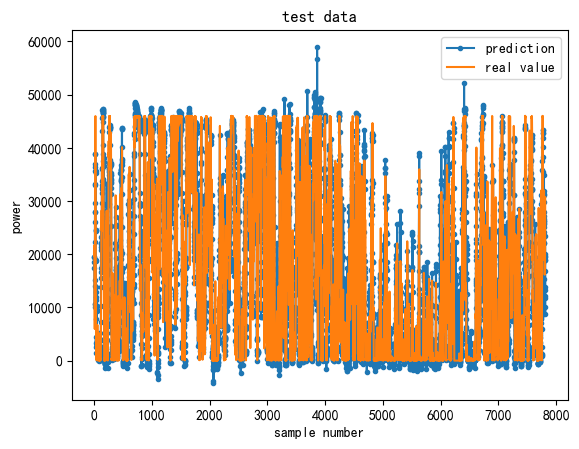

In [32]:
## BP神经网络模型
BP_a = MLPRegressor(activation='relu', hidden_layer_sizes=(32, 32), max_iter=20000, random_state=4)
BP_a.fit(train_set_a_df.iloc[:, 0:3], train_set_a_df.iloc[:, 3])
preds_a = BP_a.predict(test_set_a_df.iloc[:, 0:3])

BP_b = MLPRegressor(activation='relu', hidden_layer_sizes=(32, 32), max_iter=20000, random_state=4)
BP_b.fit(train_set_b_df.iloc[:, 0:3], train_set_b_df.iloc[:, 3])
preds_b = BP_b.predict(test_set_b_df.iloc[:, 0:3])

BP_c = MLPRegressor(activation='relu', hidden_layer_sizes=(32, 32), max_iter=20000, random_state=4)
BP_c.fit(train_set_c_df.iloc[:, 0:3], train_set_c_df.iloc[:, 3])
preds_c = BP_c.predict(test_set_c_df.iloc[:, 0:3])

# 预测结果整合
preds_total = np.zeros(shape=(test_set_df.shape[0]))
preds_total[tes_idx_a] = preds_a
preds_total[tes_idx_b] = preds_b
preds_total[tes_idx_c] = preds_c

# 预测结果反归一化
preds_matrix = np.zeros(shape=(preds_total.shape[0], 4))
preds_matrix[:, 3] = preds_total
preds_dnorm = tes_scaler.inverse_transform(preds_matrix)[:, 3]

# 平均绝对误差 mae
mae = mean_absolute_error(test_y_dnorm, preds_dnorm)
print('Mean Absolute Error:', mae)
# 均方根误差 rmse
rmse = np.sqrt(mean_squared_error(test_y_dnorm, preds_dnorm))
print('Root Mean Squared Error:', rmse)
# R2
r_squ = r2_score(test_y_dnorm, preds_dnorm)
print('R Square:', r_squ)

# 预测效果可视化
plt.figure()
plt.xlabel("sample number")
plt.ylabel("power")
plt.plot(range(test_set_df.shape[0]), preds_dnorm, '.-')
plt.plot(range(test_set_df.shape[0]), test_y_dnorm)
plt.legend(['prediction', 'real value'])
plt.title('test data')
plt.show()

Mean Absolute Error: 5179.40637122751
Root Mean Squared Error: 6809.658194653946
R Square: 0.8204102650850505


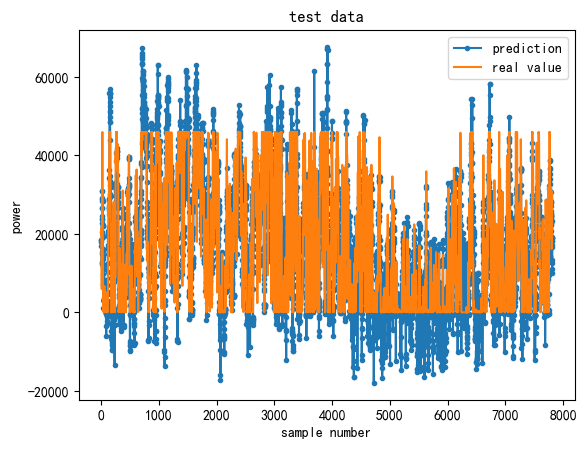

In [33]:
## 最小二乘回归模型
lsr_a = LinearRegression() # 默认存在截距
lsr_a.fit(train_set_a_df.iloc[:, 0:3], train_set_a_df.iloc[:, 3])
preds_a = lsr_a.predict(test_set_a_df.iloc[:, 0:3])

lsr_b = LinearRegression() # 默认存在截距
lsr_b.fit(train_set_b_df.iloc[:, 0:3], train_set_b_df.iloc[:, 3])
preds_b = lsr_b.predict(test_set_b_df.iloc[:, 0:3])

lsr_c = LinearRegression() # 默认存在截距
lsr_c.fit(train_set_c_df.iloc[:, 0:3], train_set_c_df.iloc[:, 3])
preds_c = lsr_c.predict(test_set_c_df.iloc[:, 0:3])

# 预测结果整合
preds_total = np.zeros(shape=test_set_df.shape[0])
preds_total[tes_idx_a] = preds_a
preds_total[tes_idx_b] = preds_b
preds_total[tes_idx_c] = preds_c

# 预测结果反归一化
preds_matrix = np.zeros(shape=(preds_total.shape[0], 4))
preds_matrix[:, 3] = preds_total
preds_dnorm = tes_scaler.inverse_transform(preds_matrix)[:, 3]

# 平均绝对误差 mae
mae = mean_absolute_error(test_y_dnorm, preds_dnorm)
print('Mean Absolute Error:', mae)
# 均方根误差 rmse
rmse = np.sqrt(mean_squared_error(test_y_dnorm, preds_dnorm))
print('Root Mean Squared Error:', rmse)
# R2
r_squ = r2_score(test_y_dnorm, preds_dnorm)
print('R Square:', r_squ)

# 预测效果可视化
plt.figure()
plt.xlabel("sample number")
plt.ylabel("power")
plt.plot(range(test_set_df.shape[0]), preds_dnorm, '.-')
plt.plot(range(test_set_df.shape[0]), test_y_dnorm)
plt.legend(['prediction', 'real value'])
plt.title('test data')
plt.show()

Mean Absolute Error: 5160.6406104391135
Root Mean Squared Error: 7008.073386763579
R Square: 0.809792269108923


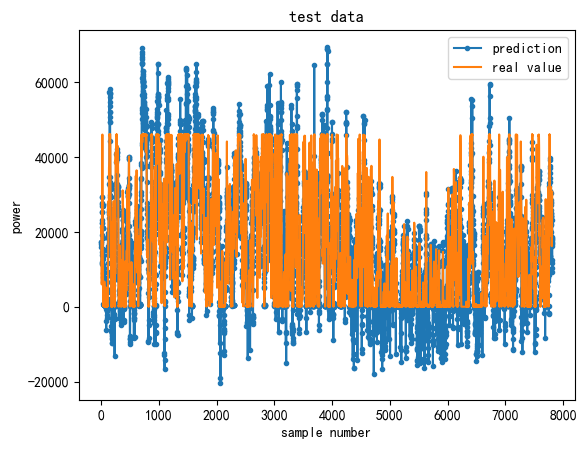

In [34]:
## SVR回归模型
svr_a = LinearSVR(max_iter=10000, random_state=4)
svr_a.fit(train_set_a_df.iloc[:, 0:3], train_set_a_df.iloc[:, 3])
preds_a = svr_a.predict(test_set_a_df.iloc[:, 0:3])

svr_b = LinearSVR(max_iter=10000, random_state=4)
svr_b.fit(train_set_b_df.iloc[:, 0:3], train_set_b_df.iloc[:, 3])
preds_b = svr_b.predict(test_set_b_df.iloc[:, 0:3])

svr_c = LinearSVR(max_iter=10000, random_state=4)
svr_c.fit(train_set_c_df.iloc[:, 0:3], train_set_c_df.iloc[:, 3])
preds_c = svr_c.predict(test_set_c_df.iloc[:, 0:3])

# 预测结果整合
preds_total = np.zeros(shape=test_set_df.shape[0])
preds_total[tes_idx_a] = preds_a
preds_total[tes_idx_b] = preds_b
preds_total[tes_idx_c] = preds_c

# 预测结果反归一化
preds_matrix = np.zeros(shape=(preds_total.shape[0], 4))
preds_matrix[:, 3] = preds_total
preds_dnorm = tes_scaler.inverse_transform(preds_matrix)[:, 3]

# 平均绝对误差 mae
mae = mean_absolute_error(test_y_dnorm, preds_dnorm)
print('Mean Absolute Error:', mae)
# 均方根误差 rmse
rmse = np.sqrt(mean_squared_error(test_y_dnorm, preds_dnorm))
print('Root Mean Squared Error:', rmse)
# R2
r_squ = r2_score(test_y_dnorm, preds_dnorm)
print('R Square:', r_squ)

# 预测效果可视化
plt.figure()
plt.xlabel("sample number")
plt.ylabel("power")
plt.plot(range(test_set_df.shape[0]), preds_dnorm, '.-')
plt.plot(range(test_set_df.shape[0]), test_y_dnorm)
plt.legend(['prediction', 'real value'])
plt.title('test data')
plt.show()